<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.ParisHousingPrices/blob/adding_more_data/2_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [2]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 'joined_dataset'
MODELS_TRIAL = 1
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/10.ParisHousePrices/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

# Download the data

In [109]:
df_source = pd.read_csv(manager.train_path, index_col='id')
df_submission = pd.read_csv(manager.test_path, index_col='id')
df_additional = pd.read_csv(f'{manager.data_root_path}/ParisHousing_additional_data.csv')
df_source.shape, df_submission.shape

((22730, 17), (15154, 16))

In [110]:
df_additional.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


In [111]:
df_source.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
id,,,,,,,,,,,,,,,,,
0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


# Join additional data (optional)

In [118]:
# Will change the index of df_additional, to avoid
# duplicate indices
df_source.index.max()
df_additional.index = np.arange(df_source.index.max()+1, df_source.index.max() + df_additional.shape[0] + 1)

In [122]:
df_source.index.max(), df_additional.index.min(), df_additional.index.max(), \
df_additional.shape[0]

(22729, 22730, 32729, 10000)

In [124]:
print(df_source.shape, df_additional.shape)
assert (df_source.columns == df_additional.columns).all()

df_source = pd.concat([df_source, df_additional])
print(f'Shape after: {df_source.shape}')

print(df_source.tail())

(22730, 17) (10000, 17)
Shape after: (32730, 17)
       squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
32725          1726             89        0        1       5     73133   
32726         44403             29        1        1      12     34606   
32727         83841              3        0        0      69     80933   
32728         59036             70        0        0      96     55856   
32729          1440             84        0        0      49     18412   

       cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
32725              7              6  2009           0                  1   
32726              9              4  1990           0                  1   
32727             10             10  2005           1                  1   
32728              1              3  2010           0                  1   
32729              6             10  1994           1                  0   

       basement  attic  garage  hasStorageRoom  h

# Clean outliers

Here, we have to duplicate the code from the data_exploration.ipynb notebook

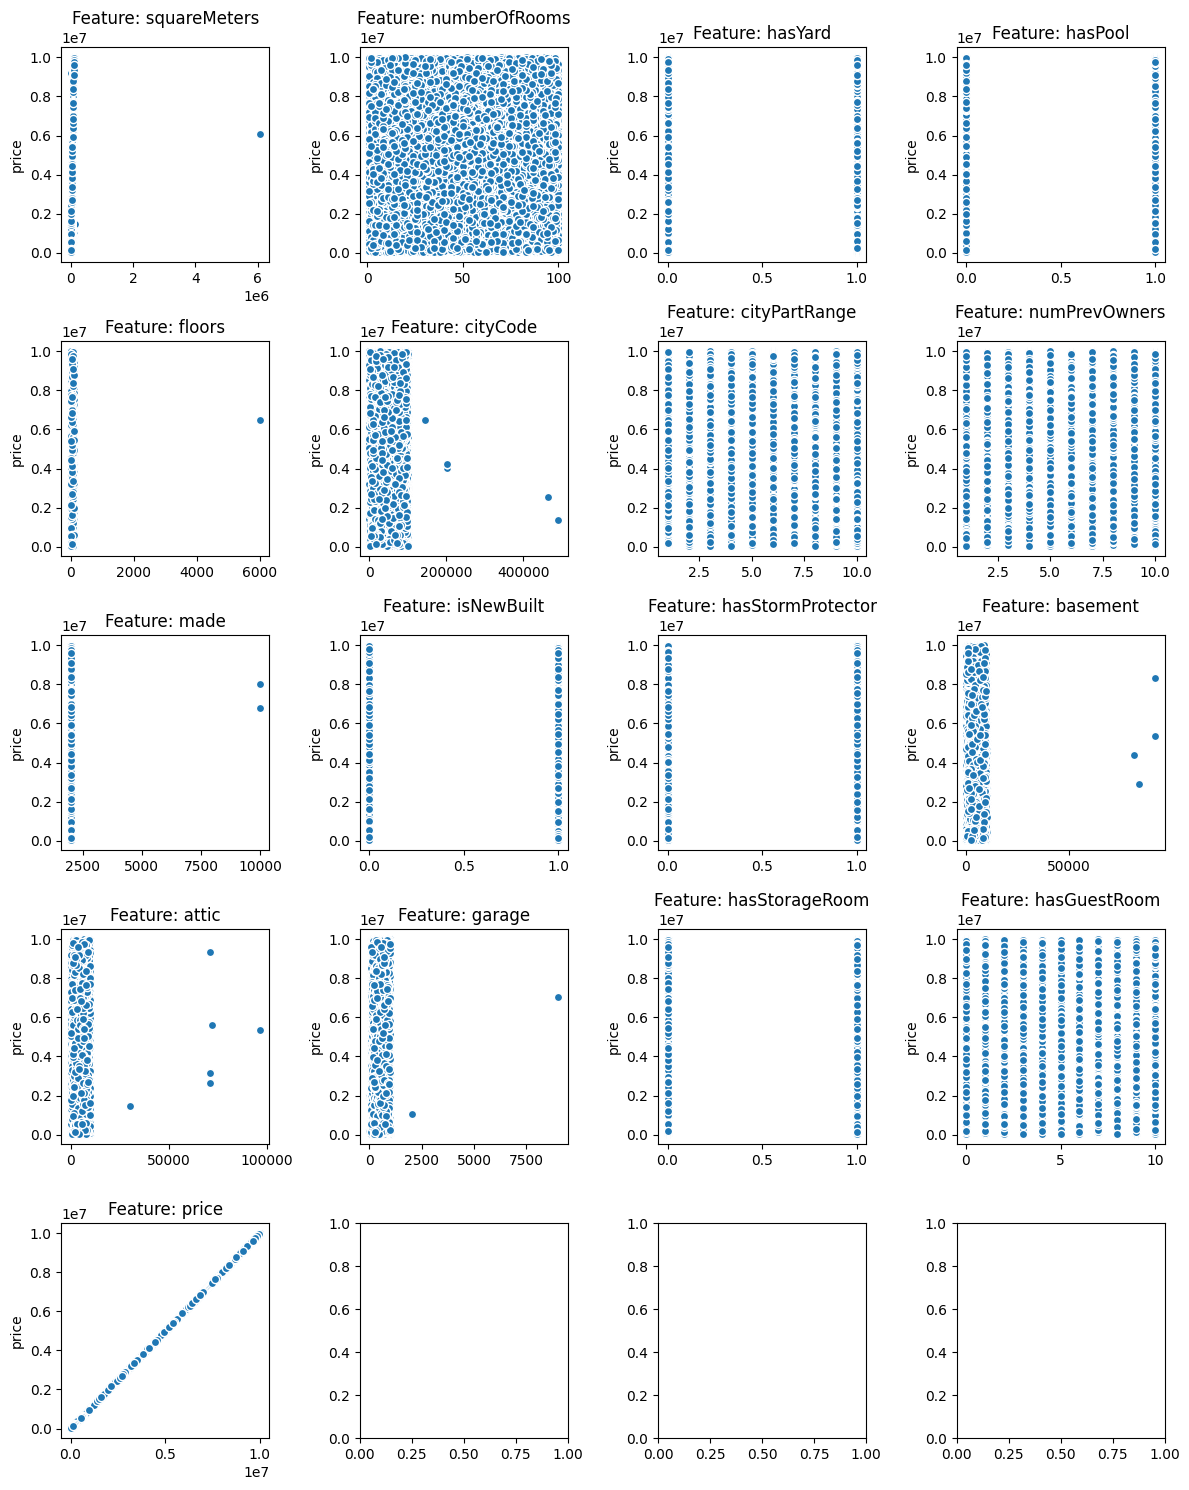

In [127]:
from sklearn_utils import visualize_target_vs_columns

visualize_target_vs_columns(
    df_source,
    'price',
    df_source.columns,
    grid_width=4,
    height_scale=3.0
)

## IQR cleaning

In [128]:
def plot_quantile_outliers(df, column_quantile_dict, n_cols=5):
    temp = len(column_quantile_dict.keys()) // n_cols
    n_rows = temp if len(column_quantile_dict.keys()) % n_cols == 0 else temp + 1

    _, ax = plt.subplots(nrows=n_rows, ncols=n_cols)
    ax = ax.flatten()
    counter = 0
    outlier_indices = list()
    for column_name, quantile in column_quantile_dict.items():

        subset = df.loc[
            df[column_name] > df_source[column_name].quantile(quantile)
        ]
        print(f'For {column_name}: {subset.shape[0]} outliers')
        print(f'Indices: {list(subset.index)}')

        outlier_indices += list(subset.index)

        ax[counter].scatter(df_source[column_name], df_source['price'])
        ax[counter].scatter(subset[column_name], subset['price'])
        ax[counter].set_ylabel('price')
        ax[counter].set_xlabel(column_name)

        counter += 1
    print(f'In total: {len(set(outlier_indices))} outliers')
    return set(outlier_indices)

For squareMeters: 33 outliers
Indices: [648, 2323, 3184, 3515, 4657, 4741, 5261, 8054, 8533, 10043, 13686, 14864, 15334, 15749, 17330, 17742, 19081, 19438, 19978, 21320, 22877, 23786, 24736, 25408, 25750, 25936, 28114, 28368, 29504, 29730, 31062, 32147, 32180]
For floors: 1 outliers
Indices: [5659]
For cityCode: 9 outliers
Indices: [299, 1326, 2425, 5480, 10987, 20576, 20735, 22631, 23101]
For made: 5 outliers
Indices: [2113, 3608, 19124, 19748, 21400]
For basement: 4 outliers
Indices: [2107, 3995, 15068, 18926]
For attic: 16 outliers
Indices: [833, 2014, 3828, 4909, 5991, 8956, 9115, 9864, 12858, 13347, 13633, 13642, 14162, 17168, 19994, 28637]
For garage: 2 outliers
Indices: [14878, 17629]
In total: 70 outliers


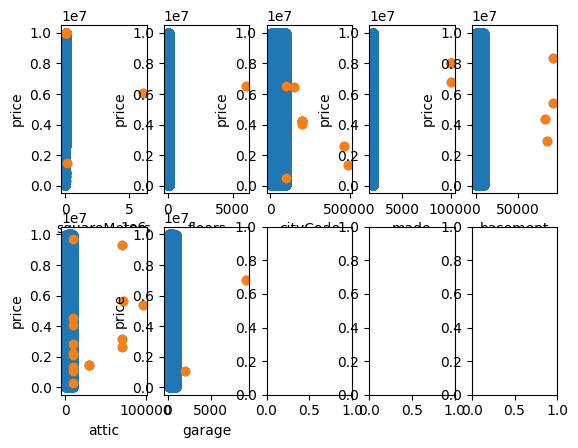

In [129]:
outlier_indices = plot_quantile_outliers(
    df_source,
    {
        'squareMeters': 0.999,
        'floors': 0.999,
        'cityCode': 0.9997,
        'made': 0.999,
        'basement': 0.9995,
        'attic': 0.9995,
        'garage': 0.999
    }
)

In [130]:
len(outlier_indices) / df_source.shape[0]

0.0021387106630003055

In [131]:
print(f'Data size before IQR cleaning: {df_source.shape}')
df_source = df_source.iloc[~df_source.index.isin(outlier_indices), :]
print(f'Data size after IQR cleaning: {df_source.shape}')

Data size before IQR cleaning: (32730, 17)
Data size after IQR cleaning: (32660, 17)


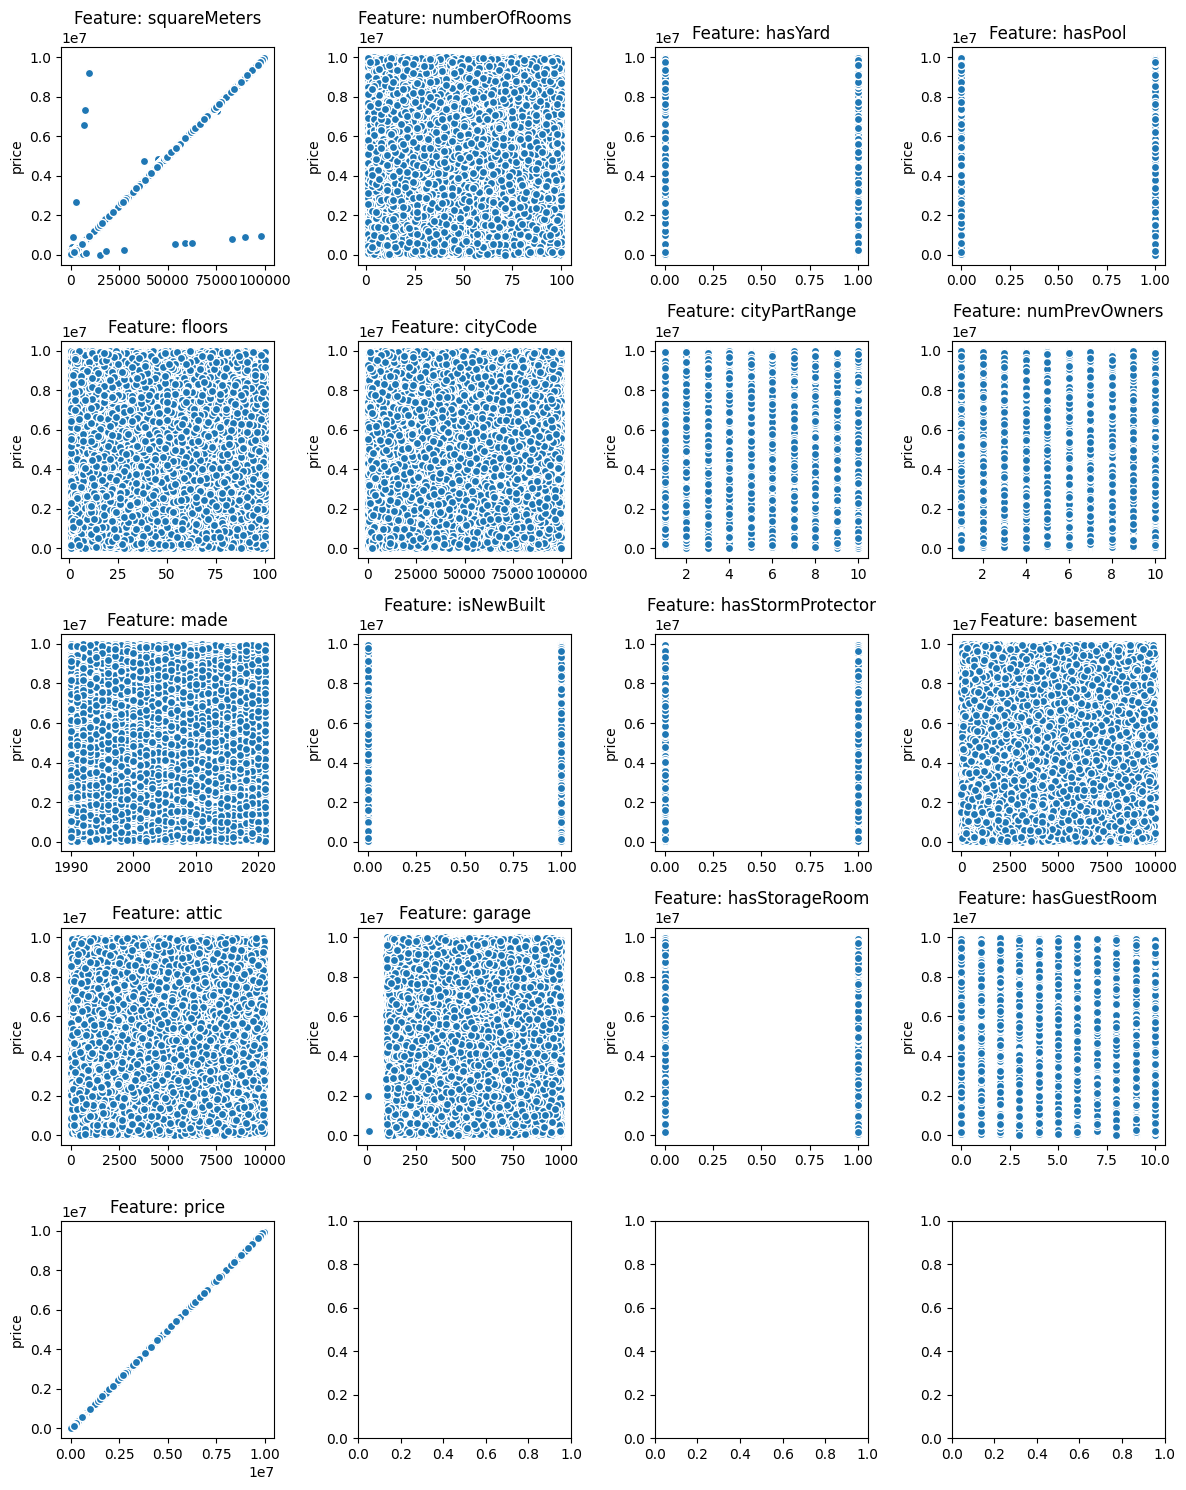

In [132]:
visualize_target_vs_columns(
    df_source,
    'price',
    df_source.columns,
    grid_width=4,
    height_scale=3.0
)

## Local outlier factor cleaning

OUTLIERS: 158


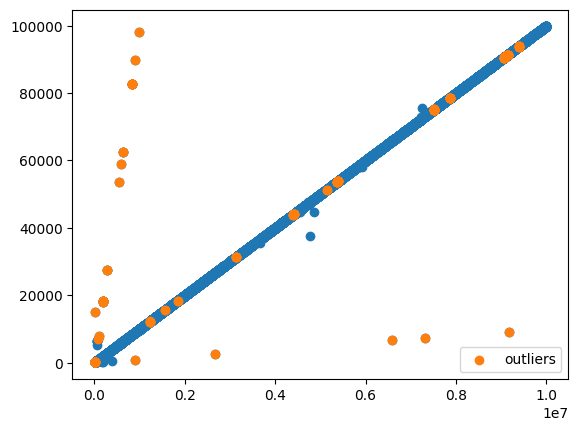

In [133]:
from sklearn.neighbors import LocalOutlierFactor


clf = LocalOutlierFactor(n_neighbors=75)  # 60
preds = clf.fit_predict(df_source[['price', 'squareMeters']])

outlier_indices = np.where(preds == -1)[0]
outlier_subset = df_source.iloc[outlier_indices]

print(f'OUTLIERS: {outlier_subset.shape[0]}')

_, ax = plt.subplots()
ax.scatter(df_source['price'], df_source['squareMeters'])
ax.scatter(outlier_subset['price'], outlier_subset['squareMeters'], label='outliers')
ax.legend()

We will clean (158,) outliers
shape before: (32660, 17)
shape after: (32502, 17)
(32502, 17)


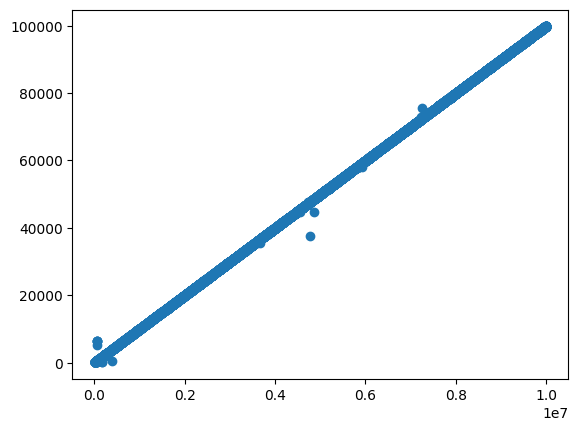

In [134]:

print(f'We will clean {outlier_indices.shape} outliers')

print(f'shape before: {df_source.shape}')
df_source = df_source.iloc[~df_source.index.isin(outlier_subset.index), :]
print(f'shape after: {df_source.shape}')

_, ax = plt.subplots()
ax.scatter(df_source['price'], df_source['squareMeters'])

print(df_source.shape)

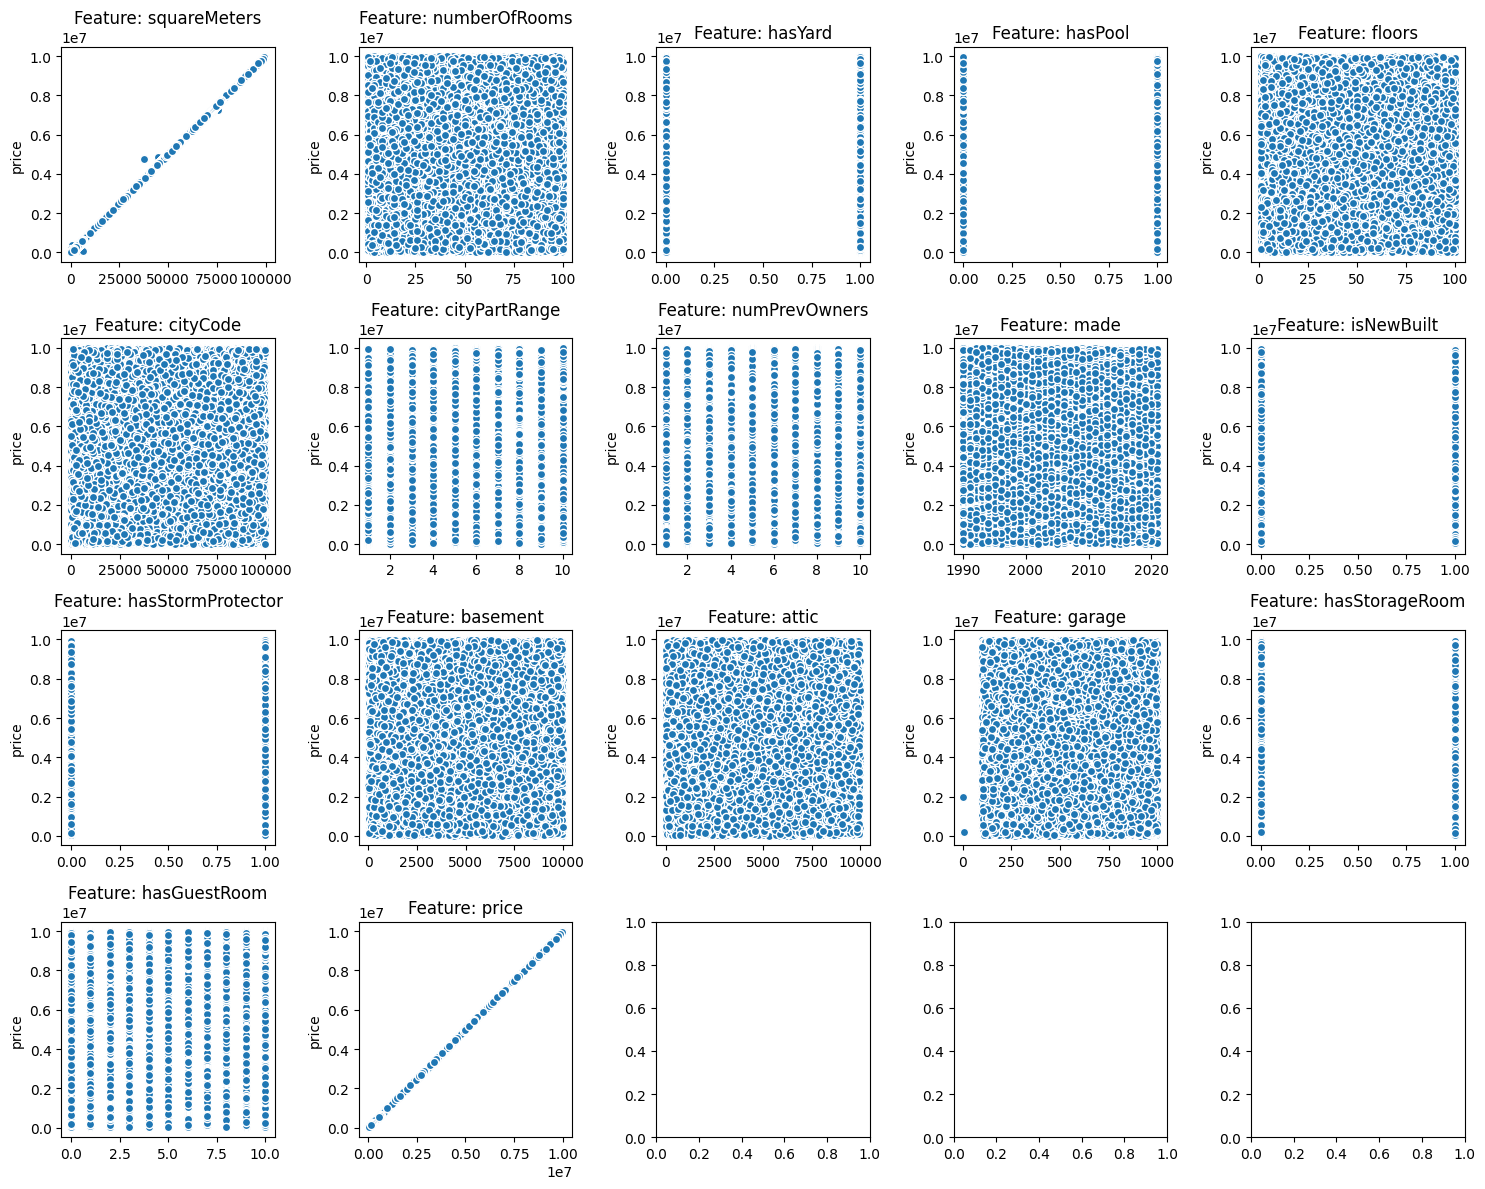

In [135]:
visualize_target_vs_columns(
    df_source,
    'price',
    df_source.columns,
    grid_width=5,
    height_scale=3.0
)

In [136]:
# (df_source['price'] / df_source['squareMeters']).mean()
# _, ax = plt.subplots()
# ax.scatter(
#     y=df_source['price'],
#     x=df_source['squareMeters']
# )
# ax.set_ylabel('price')

# x = np.linspace(df_source['squareMeters'].min(), df_source['squareMeters'].max(), 100)
# y = np.array([100.83 * x_ for x_ in x])
# OFFSET = 250000
# ax.plot(x, y + OFFSET, color='red')
# ax.plot(x, y - OFFSET, color='red')

# Split the data

In [137]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
TRAINVAL_SIZE = 0.8
TRAIN_SIZE = 0.8

df_trainval, df_test = train_test_split(
    df_source,
    random_state=RANDOM_STATE,
    train_size=TRAINVAL_SIZE
)

df_train, df_val = train_test_split(
    df_trainval,
    random_state=RANDOM_STATE,
    train_size=TRAIN_SIZE
)

df_train.shape, df_val.shape, df_test.shape

((20800, 17), (5201, 17), (6501, 17))

In [138]:
def X_Y(df, y=True):
    X = df.loc[:, df.columns != 'price']
    if y:
        Y = df['price']
    else:
        Y = None
    return X, Y

X_train, Y_train = X_Y(df_train)
X_val, Y_val = X_Y(df_val)
X_test, Y_test = X_Y(df_test)
X_submission, _ = X_Y(df_submission, y=False)

for x in [X_train, X_val, X_test, X_submission]:
    print(x.shape)
for y in [Y_train, Y_val, Y_test]:
    print(y.shape)

(20800, 16)
(5201, 16)
(6501, 16)
(15154, 16)
(20800,)
(5201,)
(6501,)


In [139]:
Xs = [X_train, X_val, X_test, X_submission]
Ys = [Y_train, Y_val, Y_test, None]

In [158]:
def report_dataset_arrays(Xs, Ys):
    for x, y in zip(Xs, Ys):
        if y is not None:
            print(x.shape, y.shape)
        else:
            print(x.shape)

report_dataset_arrays(Xs, Ys)

(20800, 52) (20800,)
(5201, 52) (5201,)
(6501, 52) (6501,)
(15154, 52)


# Feature engineering

## Room size (square meter per room)

In [141]:
f = 'squareMeterPerRoom'

def add_square_meter_per_room(df):
    df[f] = df['squareMeters'] / df['numberOfRooms']


for i, x in enumerate(Xs):
    print(Xs[i].shape)
    x = add_square_meter_per_room(x)
    print(Xs[i].shape)

(20800, 16)
(20800, 17)
(5201, 16)
(5201, 17)
(6501, 16)
(6501, 17)
(15154, 16)
(15154, 17)


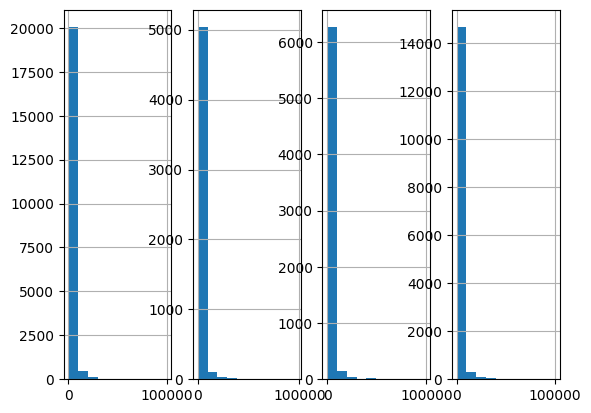

In [142]:
_, ax = plt.subplots(1, 4)
for i, x in enumerate(Xs):
    x['squareMeterPerRoom'].hist(
        ax=ax[i]
    )


<Axes: >

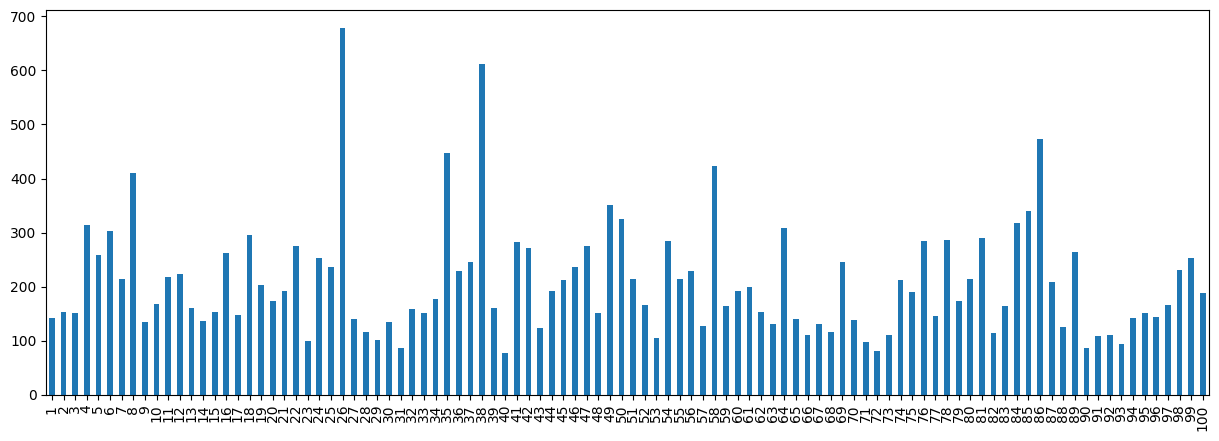

In [143]:
Xs[0]['numberOfRooms'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

<Axes: >

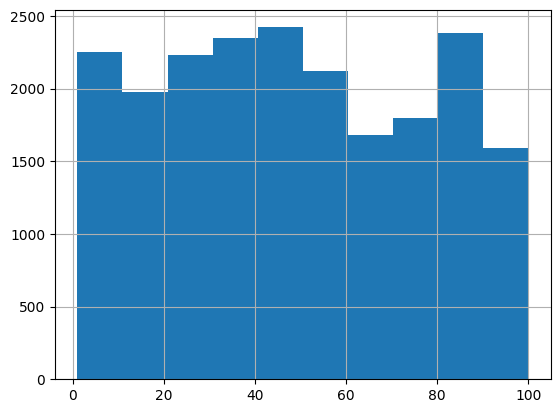

In [144]:
Xs[0]['numberOfRooms'].hist()

In [145]:
Xs[0].squareMeterPerRoom.max()

99365.0

In [146]:
Xs[0][Xs[0]['squareMeterPerRoom'] > 40000].head(100)

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,squareMeterPerRoom
17652,98094,2,0,1,29,97750,4,2,2009,0,0,6126,9708,238,1,8,49047.0
8754,95444,2,0,0,1,94707,1,2,2000,1,0,4292,3214,239,1,4,47722.0
32306,81458,1,1,0,22,64994,9,6,1992,0,0,5742,856,984,1,5,81458.0
26952,44251,1,0,1,48,93033,1,9,2007,0,0,7723,2912,256,0,10,44251.0
12929,83606,2,0,0,95,52889,1,2,2000,0,0,3382,2699,922,1,9,41803.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7321,51891,1,0,1,100,93977,6,9,2018,0,0,8160,473,686,1,0,51891.0
30226,68010,1,1,1,71,65943,1,1,2010,1,1,612,1124,769,0,9,68010.0
31927,85030,1,1,0,48,19069,6,5,2009,0,0,7631,476,815,0,4,85030.0
31181,69242,1,0,1,83,68161,2,9,2014,1,1,772,1479,153,0,0,69242.0


## boxesChecked

In [147]:
def add_boxes_checked(df):
    df['boxesChecked'] = \
        df['hasYard'] + \
        df['hasPool'] + \
        df['hasStormProtector'] + \
        df['hasStorageRoom'] + \
        df['isNewBuilt'] + \
        (df['hasGuestRoom'] > 0)

for i, x in enumerate(Xs):
    print(Xs[i].shape)
    x = add_boxes_checked(x)
    print(Xs[i].shape)
    print()

(20800, 17)
(20800, 18)

(5201, 17)
(5201, 18)

(6501, 17)
(6501, 18)

(15154, 17)
(15154, 18)



## floorsBinned

In [148]:
ser, floor_bins = pd.qcut(
    Xs[0]['floors'],
    q=np.linspace(0, 1, num=13),
    labels=False,
    retbins=True
)

In [149]:
def bin_column(df, column, bins):
    # bins can be learned as:
    # series_bins = pd.qcut(
    #     df[feature],
    #     q=np.linspace(0, 1, num=13),
    #     labels=False,
    #     retbins=True
    # )
    df[f'{column}_binned'] = pd.cut(
        df[column],
        bins=bins,
        labels=False,
        include_lowest=True
    )
    assert df[f'{column}_binned'].value_counts().sum() == df.shape[0], print(df[f'{column}_binned'].value_counts().sum(), df.shape[0])


In [150]:
for i, x in enumerate(Xs):
    print(Xs[i].shape)
    x = bin_column(x, 'floors', bins=floor_bins)
    print(Xs[i].shape)
    print()

(20800, 18)
(20800, 19)

(5201, 18)
(5201, 19)

(6501, 18)
(6501, 19)

(15154, 18)
(15154, 19)



## Binned cityCode

In [ ]:
_, city_code_bins = pd.qcut(
    Xs[0]['cityCode'],
    q=np.linspace(0, 1, num=13),
    labels=False,
    retbins=True
)

In [ ]:
Xs[0].cityCode_binned.value_counts().sum(), Xs[0].shape[0]

(14361, 14361)

In [ ]:
# for i, x in enumerate(Xs):
#     print(Xs[i].shape)
#     x = bin_column(x, 'cityCode', bins=city_code_bins)
#     print(Xs[i].shape)
#     print()

## Feature cross for boolean variables

In [151]:
def add_category(df):
    df['ApartmentCharacteristic'] = df.apply(
        lambda item: f'{int(item["hasYard"])}x{int(item["hasPool"])}x{int(item["isNewBuilt"])}x{int(item["hasStormProtector"])}x{int(item["hasStorageRoom"])}',
        axis='columns'
    )
    return df

for i, data in enumerate(Xs):
    print('Shape before', data.shape)
    data = add_category(data)
    print('Shape after', Xs[i].shape)

Shape before (20800, 19)
Shape after (20800, 20)
Shape before (5201, 19)
Shape after (5201, 20)
Shape before (6501, 19)
Shape after (6501, 20)
Shape before (15154, 19)
Shape after (15154, 20)


In [152]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(Xs[0][['ApartmentCharacteristic']])
encoder.categories_, len(encoder.categories_[0])

([array(['0x0x0x0x0', '0x0x0x0x1', '0x0x0x1x0', '0x0x0x1x1', '0x0x1x0x0',
         '0x0x1x0x1', '0x0x1x1x0', '0x0x1x1x1', '0x1x0x0x0', '0x1x0x0x1',
         '0x1x0x1x0', '0x1x0x1x1', '0x1x1x0x0', '0x1x1x0x1', '0x1x1x1x0',
         '0x1x1x1x1', '1x0x0x0x0', '1x0x0x0x1', '1x0x0x1x0', '1x0x0x1x1',
         '1x0x1x0x0', '1x0x1x0x1', '1x0x1x1x0', '1x0x1x1x1', '1x1x0x0x0',
         '1x1x0x0x1', '1x1x0x1x0', '1x1x0x1x1', '1x1x1x0x0', '1x1x1x0x1',
         '1x1x1x1x0', '1x1x1x1x1'], dtype=object)],
 32)

In [153]:
def do_feature_cross(df, column_name, trained_one_hot_encoder):
    assert column_name in df.columns, print(f'{column_name} is not in columns')

    categories_in_df = df[column_name].unique()
    for cat in categories_in_df:
        assert cat in trained_one_hot_encoder.categories_[0], \
            print(f'Category {cat} is not learned, but is in the dataframe')

    print(f'NANs before preprocessing: {df.isna().sum().sum()}')
    transformed_df = pd.DataFrame(encoder.transform(df[[column_name]]).toarray())

    # Aligning index to avoid NAN after join
    transformed_df.index = df.index
    df = df.join(transformed_df)
    df.columns = df.columns.astype(str)
    print(f'NANs after preprocessing: {df.isna().sum().sum()}')
    return df

In [154]:
for i in range(len(Xs)):
    print(f'Working with {i}')
    print(f'Shape before: {Xs[i].shape}')
    Xs[i] = do_feature_cross(Xs[i], 'ApartmentCharacteristic', encoder)
    print(f'Shape after:', Xs[i].shape)
    print()

Working with 0
Shape before: (20800, 20)
NANs before preprocessing: 0
NANs after preprocessing: 0
Shape after: (20800, 52)

Working with 1
Shape before: (5201, 20)
NANs before preprocessing: 0
NANs after preprocessing: 0
Shape after: (5201, 52)

Working with 2
Shape before: (6501, 20)
NANs before preprocessing: 0
NANs after preprocessing: 0
Shape after: (6501, 52)

Working with 3
Shape before: (15154, 20)
NANs before preprocessing: 0
NANs after preprocessing: 0
Shape after: (15154, 52)



# Preprocessing pipeline

In [159]:
report_dataset_arrays(Xs, Ys)

(20800, 52) (20800,)
(5201, 52) (5201,)
(6501, 52) (6501,)
(15154, 52)


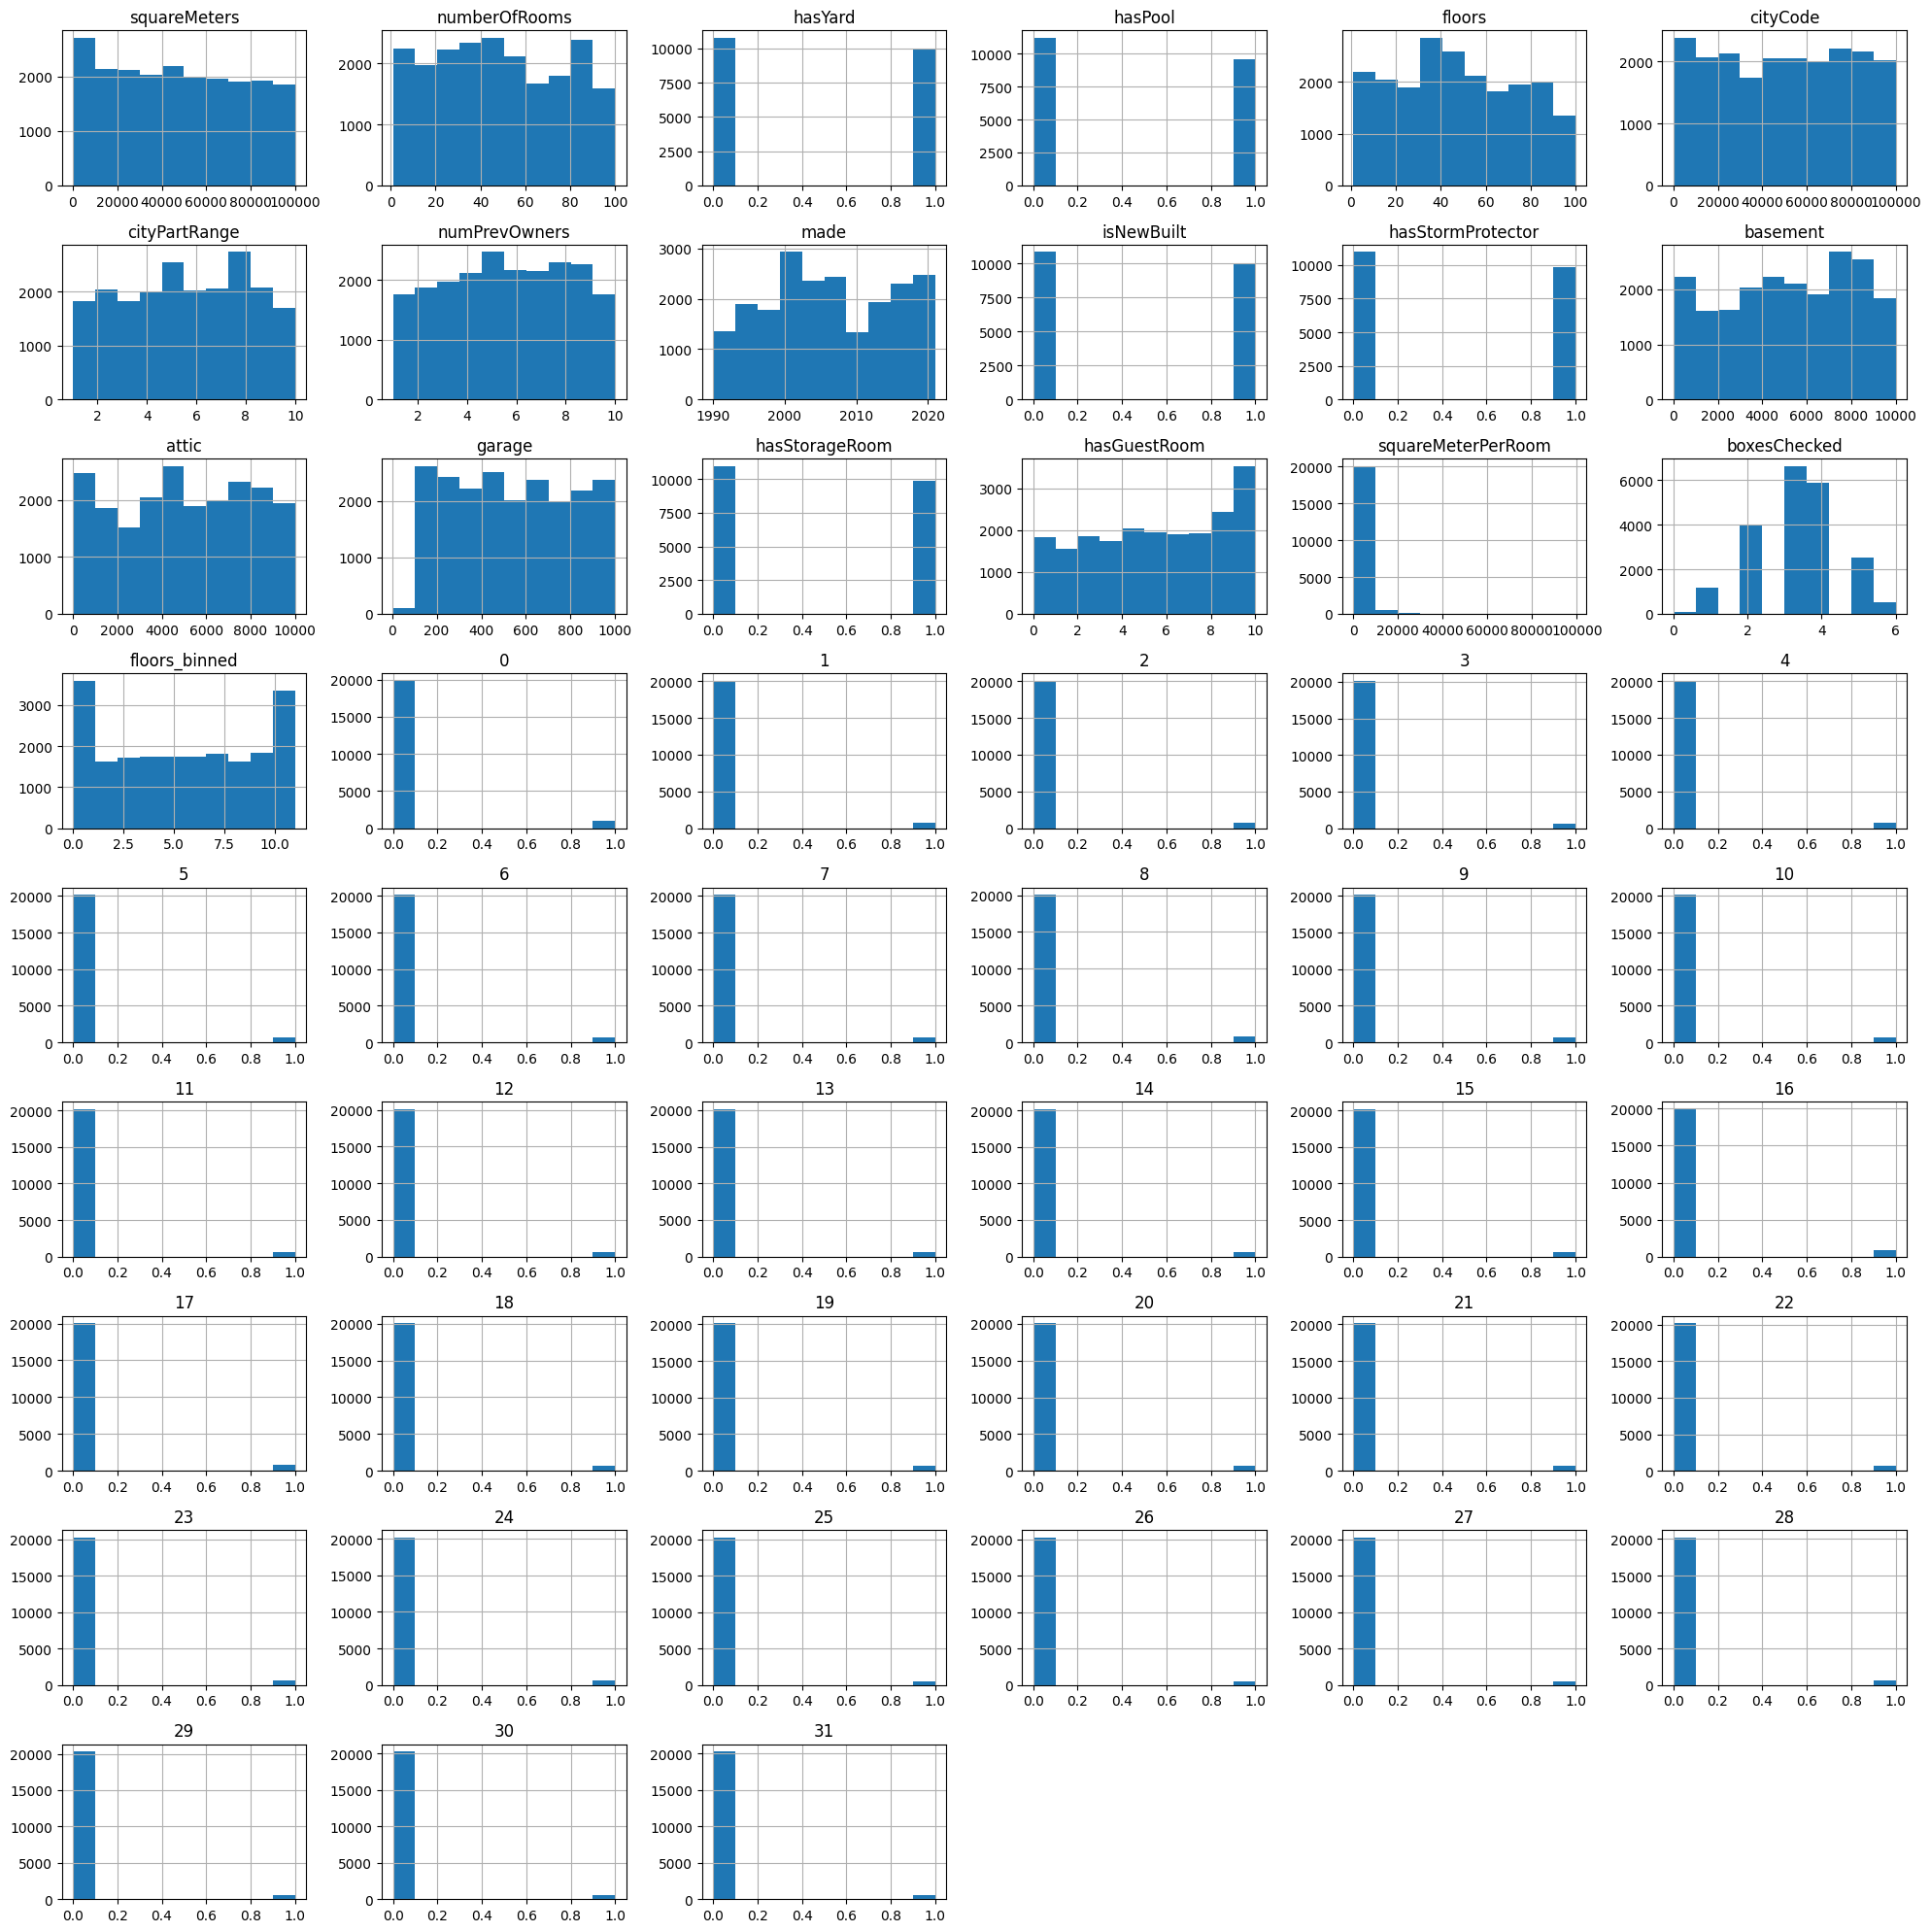

In [160]:
_ = Xs[0].hist(figsize=(20, 20), layout=(9, 6))
plt.tight_layout()

In [161]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_cols = [
    #
]

cols_to_min_max_scale = [
    'squareMeters',
    'numberOfRooms',
    'floors',
    'cityPartRange',
    'numPrevOwners',
    'made',
    'basement',
    'attic',
    'garage',
    'hasGuestRoom',
    'hasYard',
    'hasPool',
    'isNewBuilt',
    'hasStormProtector',
    'hasStorageRoom',
    'cityCode',
    'squareMeterPerRoom',
    'boxesChecked',
    'floors_binned',
    *[str(i) for i in range(0, 32)]
]

cols_to_drop = [
    'ApartmentCharacteristic',
    # 'squareMeterPerRoom'
]

In [162]:
Xs[0].columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'squareMeterPerRoom', 'boxesChecked', 'floors_binned',
       'ApartmentCharacteristic', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'],
      dtype='object')

In [163]:
total_cols = set(
    [
        *num_cols,
        *cols_to_min_max_scale,
        *cols_to_drop
    ]
)

for i in range(len(Xs)):
    assert set(Xs[i].columns) - total_cols == set()

In [164]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

num_pipeline = make_pipeline(
    StandardScaler()
)

min_max_pipeline = make_pipeline(
    MinMaxScaler()
)

preprocessor = ColumnTransformer(
    transformers=[
        # ('num', num_pipeline, num_cols),
        ('min_max', min_max_pipeline, cols_to_min_max_scale),
        # ()
    ],
    remainder='drop'
)

In [165]:
for i in range(len(Xs)):
    print(f'Shape before: {Xs[i].shape}')
    if i == 0:
        Xs[i] = preprocessor.fit_transform(Xs[i])  # train set
    else:
        Xs[i] = preprocessor.transform(Xs[i])
    print(f'Shape after: {Xs[i].shape}')
    print()

Shape before: (20800, 52)
Shape after: (20800, 51)

Shape before: (5201, 52)
Shape after: (5201, 51)

Shape before: (6501, 52)
Shape after: (6501, 51)

Shape before: (15154, 52)
Shape after: (15154, 51)



# Save the data

In [166]:
manager.data_trial_path

'/content/gdrive/MyDrive/ML/Competitions/10.ParisHousePrices/Data/preproc_trial_joined_dataset'

In [167]:
Ys[0].shape, np.expand_dims(Ys[0], axis=0).shape

((20800,), (1, 20800))

In [168]:
report_dataset_arrays(Xs, Ys)

(20800, 51) (20800,)
(5201, 51) (5201,)
(6501, 51) (6501,)
(15154, 51)


In [169]:
for i in range(len(Xs)):
    print(Xs[i].shape)
    if Ys[i] is not None:
        Xs[i] = np.hstack([Xs[i], np.expand_dims(Ys[i], axis=-1)])
    print(Xs[i].shape)
    print()

(20800, 51)
(20800, 52)

(5201, 51)
(5201, 52)

(6501, 51)
(6501, 52)

(15154, 51)
(15154, 51)



In [170]:
pd.DataFrame(Xs[0]).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
0,0.359443,0.121212,0.313131,0.333333,0.000000,0.193548,0.3775,0.920084,0.449799,0.0,0.0,0.0,0.0,0.0,1.0,0.608543,0.027825,0.166667,0.272727,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3601900.6
1,0.337586,0.232323,0.060606,0.000000,0.333333,0.096774,0.0928,0.836967,0.823293,0.4,1.0,1.0,1.0,1.0,1.0,0.303031,0.014151,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3384758.3
2,0.901478,0.404040,0.333333,0.222222,0.444444,0.774194,0.5202,0.414583,0.284137,0.8,1.0,1.0,1.0,0.0,0.0,0.893493,0.022076,0.666667,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9004222.0
3,0.930998,0.505051,0.373737,0.888889,1.000000,0.354839,0.0389,0.492398,0.511044,0.3,0.0,0.0,1.0,0.0,1.0,0.850686,0.018325,0.500000,0.363636,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9298850.1
4,0.429438,0.151515,0.606061,1.000000,0.111111,0.322581,0.4896,0.489598,0.392570,0.0,1.0,0.0,1.0,1.0,1.0,0.441408,0.026994,0.666667,0.636364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4302940.2


In [171]:
for x in Xs:
    print(x[:, :-1].min(), x[:, :-1].max())

0.0 1.0
0.0 1.0
-0.00017052350716700274 1.0
-0.0005918168778148917 9.785634950018512


In [172]:
manager.data_trial_path

'/content/gdrive/MyDrive/ML/Competitions/10.ParisHousePrices/Data/preproc_trial_joined_dataset'

In [173]:
manager.save_to_csv(Xs[0], path_=manager.data_trial_path, file_name_='train_processed.csv')
manager.save_to_csv(Xs[1], path_=manager.data_trial_path, file_name_='val_processed.csv')
manager.save_to_csv(Xs[2], path_=manager.data_trial_path, file_name_='test_processed.csv')
manager.save_to_csv(Xs[3], path_=manager.data_trial_path, file_name_='submission_processed.csv')

# Conclusions